<a href="https://colab.research.google.com/github/leviitta/TopicosEspecialidadCienciaDatos-GRD/blob/main/Topicos_de_especialidad_Ciencia_de_Datos_GRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder # <-- Importación clave
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
import warnings
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA

In [3]:
warnings.filterwarnings('ignore')

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def construir_columna_label(df, nombre_columna):
    """
    Divide una columna de un DataFrame en cuatro nuevas columnas basadas en un patrón específico.

    Args:
        df (pd.DataFrame): El DataFrame que contiene la columna a procesar.
        nombre_columna (str): El nombre de la columna que se va a dividir.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con las columnas resultantes.
    """
    # Se define una expresión regular para capturar las diferentes partes del texto.
    # Grupo 1 (\d+): Captura el código numérico completo (ej: 184101).
    # Grupo 2 ([A-Z]{2}): Captura el código de dos letras (ej: MH).
    # Grupo 3 ([^W/]+): Captura la descripción principal hasta encontrar "W/" o el final.
    # Grupo 4 (W\/\w+)? : Captura la parte opcional que empieza con "W/" (ej: W/CC).
    patron = re.compile(r'(\d+)\s*-\s*([A-Z]{2})\s*([^W/]+)(\s*W\/\w+)?')

    # Se extraen las partes del texto en nuevas columnas temporales.
    partes = df[nombre_columna].str.extract(patron)
    partes.columns = ['num_completo', 'codigo_letra', 'descripcion', 'sufijo']

    # Se construyen las nuevas columnas a partir de las partes extraídas.
    df['Label'] = partes['num_completo'].str[:-1] + ' - ' + partes['descripcion'].str.strip()
    #df['Gravedad'] = partes['num_completo'].str[-1]
    #df['Descripcion'] = partes['codigo_letra']
    #df['Codigo'] = partes['sufijo'].str.strip().fillna('') # Rellena valores nulos con ""
    df = df.drop ('GRD', axis = 1)

    return df

In [6]:
def eliminar_label_por_porcentaje(df, columna_categoria, porcentaje_minimo):
    """
    Elimina las filas de un DataFrame pertenecientes a categorías que no alcanzan
    un porcentaje mínimo del total de filas.

    Parámetros:
    ----------
    df : pandas.DataFrame
        El DataFrame de entrada.
    columna_categoria : str
        El nombre de la columna que contiene las categorías.
    porcentaje_minimo : float
        El porcentaje mínimo que una categoría debe tener para no ser eliminada (entre 0 y 1).

    Retorna:
    -------
    pandas.DataFrame
        Un nuevo DataFrame con las filas de las categorías minoritarias eliminadas.
    """
    # Calcula el porcentaje de cada categoría
    porcentajes = df[columna_categoria].value_counts(normalize=True)

    # Identifica las categorías que están por debajo del umbral
    categorias_a_eliminar = porcentajes[porcentajes < porcentaje_minimo].index.tolist()

    # Filtra el DataFrame para mantener solo las categorías que superan el umbral
    df_filtrado = df[~df[columna_categoria].isin(categorias_a_eliminar)]

    return df_filtrado

In [7]:
def eliminar_filas_nulas_x_porcentaje(df: pd.DataFrame, porcentaje_nulos_maximo: float) -> pd.DataFrame:
    """
    Limpia un DataFrame de pandas realizando dos operaciones:
    1. Convierte todas las celdas que contienen únicamente "-" a valores nulos (NaN).
    2. Elimina las filas que superan un umbral de porcentaje de valores nulos.

    Args:
        df (pd.DataFrame): El DataFrame de pandas que se va a limpiar.
        porcentaje_nulos_maximo (float): El porcentaje máximo de nulos permitido en una fila
                                         (un número entre 0 y 100). Las filas que superen
                                         este porcentaje serán eliminadas.

    Returns:
        pd.DataFrame: Un nuevo DataFrame limpio sin las filas y con los valores nulos
                      correctamente formateados.
    """
    if not 0 <= porcentaje_nulos_maximo <= 100:
        raise ValueError("El 'porcentaje_max_nulos' debe ser un número entre 0 y 100.")

    # Es una buena práctica trabajar sobre una copia para no modificar el DataFrame original.
    df_limpio = df.copy()

    # 1. Transformar a nulos todas las celdas iguales a "-"
    # Usamos np.nan de la librería numpy, que es el estándar para representar nulos en pandas.
    print(f"Paso 1: Reemplazando '-' con valores nulos (NaN)...")
    df_limpio.replace("-", np.nan, inplace=True)

    # 2. Eliminar filas que tengan un porcentaje X de nulos.
    print(f"Paso 2: Eliminando filas con más de un {porcentaje_nulos_maximo}% de valores nulos...")

    # Calculamos el umbral como una proporción (de 0 a 1)
    umbral = porcentaje_nulos_maximo / 100.0

    # Calculamos el número mínimo de valores NO nulos que una fila debe tener para ser conservada.
    total_columnas = len(df_limpio.columns)
    min_valores_no_nulos = int(total_columnas * (1 - umbral))

    # Usamos el método dropna con el parámetro 'thresh'.
    # 'thresh' conserva las filas que tienen al menos esa cantidad de valores no nulos.
    df_limpio = df_limpio.dropna(thresh=min_valores_no_nulos)

    print("¡Limpieza completada!")
    return df_limpio

In [8]:
def eliminar_columnas_nulas_x_porcentaje(df: pd.DataFrame, porcentaje_max_nulos: float) -> pd.DataFrame:
    """
    Elimina las columnas de un DataFrame que superan un porcentaje máximo de valores nulos.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que se va a limpiar.
        porcentaje_max_nulos (float): El porcentaje máximo de valores nulos permitido en una
                                      columna (un número entre 0 y 100).

    Returns:
        pd.DataFrame: Un nuevo DataFrame sin las columnas que excedieron el umbral de nulos.

    Raises:
        ValueError: Si el porcentaje_max_nulos no está entre 0 y 100.
    """
    if not 0 <= porcentaje_max_nulos <= 100:
        raise ValueError("El 'porcentaje_max_nulos' debe ser un número entre 0 y 100.")

    # Es una buena práctica trabajar sobre una copia para no modificar el DataFrame original.
    df_limpio = df.copy()

    # 0. Transformar a nulos todas las celdas iguales a "-"
    df_limpio = df_limpio.replace('-', np.nan)

    # 1. Calcular el umbral como una proporción (ej. 30% -> 0.30)
    umbral = porcentaje_max_nulos / 100.0

    # 2. Calcular el porcentaje de nulos para cada columna
    porcentaje_nulos = df.isnull().sum() / len(df)

    # 3. Identificar las columnas que se deben eliminar
    #    Estas son las columnas donde el porcentaje de nulos es MAYOR que el umbral
    columnas_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral].index.tolist()

    if columnas_a_eliminar:
        print(f"Columnas a eliminar ({len(columnas_a_eliminar)}): {columnas_a_eliminar}")
        # 4. Eliminar esas columnas y devolver una copia del DataFrame modificado
        df_limpio = df.drop(columns=columnas_a_eliminar)
        return df_limpio
    else:
        print("No se encontraron columnas que superen el umbral de nulos.")
        return df.copy() # Devolver una copia para mantener la consistencia

In [9]:
def plot_distribucion_label(df):
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.figure(figsize=(12, 30))
  sns.countplot(y=df['Label'], order=df['Label'].value_counts().index, palette='viridis')
  plt.title('Distribución de la Variable Objetivo (GRD)', fontsize=16)
  plt.xlabel('Frecuencia', fontsize=12)
  plt.ylabel('GRD', fontsize=12)
  plt.tight_layout()
  plt.show()

In [10]:
def plot_distribucion_edad(df):
  plt.figure(figsize=(10, 6))
  sns.histplot(df['Edad en años'], bins=30, kde=True, color='skyblue')
  plt.title('Distribución de Edad de los Pacientes', fontsize=16)
  plt.xlabel('Edad en años', fontsize=12)
  plt.ylabel('Frecuencia', fontsize=12)
  plt.show()

In [11]:
def plot_distribucion_sexo(df):
  plt.figure(figsize=(8, 5))
  sns.countplot(x=df['Sexo (Desc)'], palette='pastel')
  plt.title('Distribución por Género', fontsize=16)
  plt.xlabel('Sexo', fontsize=12)
  plt.ylabel('Cantidad', fontsize=12)
  plt.show()

In [12]:
def imputar_numericas_con_mediana(df):
  """
  Imputa los valores faltantes en todas las columnas numéricas de un DataFrame
  con la mediana de cada columna.

  Args:
    df (pd.DataFrame): El DataFrame que contiene los datos a imputar.

  Returns:
    pd.DataFrame: El DataFrame con los valores numéricos faltantes imputados.
  """
  # Seleccionamos solo las columnas que son de tipo numérico
  columnas_numericas = df.select_dtypes(include=np.number).columns

  # Iteramos sobre cada columna numérica
  for col in columnas_numericas:
    # Calculamos la mediana de la columna
    mediana = df[col].median()
    # Rellenamos los valores nulos (NaN) en esa columna con la mediana
    df[col].fillna(mediana, inplace=True)

  return df

In [13]:
def imputar_categoricas_con_moda(df):
  """
  Imputa los valores faltantes en todas las columnas categóricas (tipo 'object')
  de un DataFrame con la moda de cada columna.

  Args:
    df (pd.DataFrame): El DataFrame que contiene los datos a imputar.

  Returns:
    pd.DataFrame: El DataFrame con los valores categóricos faltantes imputados.
  """
  # Seleccionamos las columnas de tipo 'object' o 'category'
  columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns

  # Iteramos sobre cada columna categórica
  for col in columnas_categoricas:
    # Calculamos la moda. .mode() devuelve una Serie, tomamos el primer elemento [0]
    # en caso de que haya múltiples modas.
    moda = df[col].mode()[0]
    # Rellenamos los valores nulos (NaN) en esa columna con la moda
    df[col].fillna(moda, inplace=True)

  return df

In [14]:
ruta_data_set_GRD = 'gdrive/My Drive/Universidad/Magister Unab/Ramos/Topico de especialidad: Ciencia de datos/Proyecto/dataset/dataset_elpino.csv'
dset_GRD = pd.read_csv(ruta_data_set_GRD, sep =';')

In [15]:
dset_GRD = construir_columna_label(dset_GRD, 'GRD')

In [16]:
# Mostrar las primeras 5 filas
print("--- Primeras 5 filas del dataset ---")
print(dset_GRD.head())

# Mostrar información general y tipos de datos
print("\n--- Información del Dataset (.info()) ---")
dset_GRD.info(verbose=False) # Se usa verbose=False para acortar la salida

# Mostrar estadísticas descriptivas para variables numéricas
print("\n--- Estadísticas Descriptivas (.describe()) ---")
print(dset_GRD.describe())

--- Primeras 5 filas del dataset ---
                         Diag 01 Principal (cod+des)  \
0            A41.8 - Otras septicemias especificadas   
1               U07.1 - COVID-19, virus identificado   
2  K56.5 - Adherencias [bridas] intestinales con ...   
3  K76.8 - Otras enfermedades especificadas del h...   
4  T81.0 - Hemorragia y hematoma que complican un...   

                        Diag 02 Secundario (cod+des)  \
0     B37.6 - Endocarditis debida a candida (I39.8*)   
1              J12.8 - Neumonía debida a otros virus   
2                              R57.2 - Shock séptico   
3                              K66.1 - Hemoperitoneo   
4  Y83.2 - Operación quirúrgica con anastomosis, ...   

                        Diag 03 Secundario (cod+des)  \
0  I39.8 - Endocarditis, válvula no especificada,...   
1                                     R06.0 - Disnea   
2                        R57.1 - Choque hipovolémico   
3        N18.5 - Enfermedad renal crónica, estadio 5   
4        

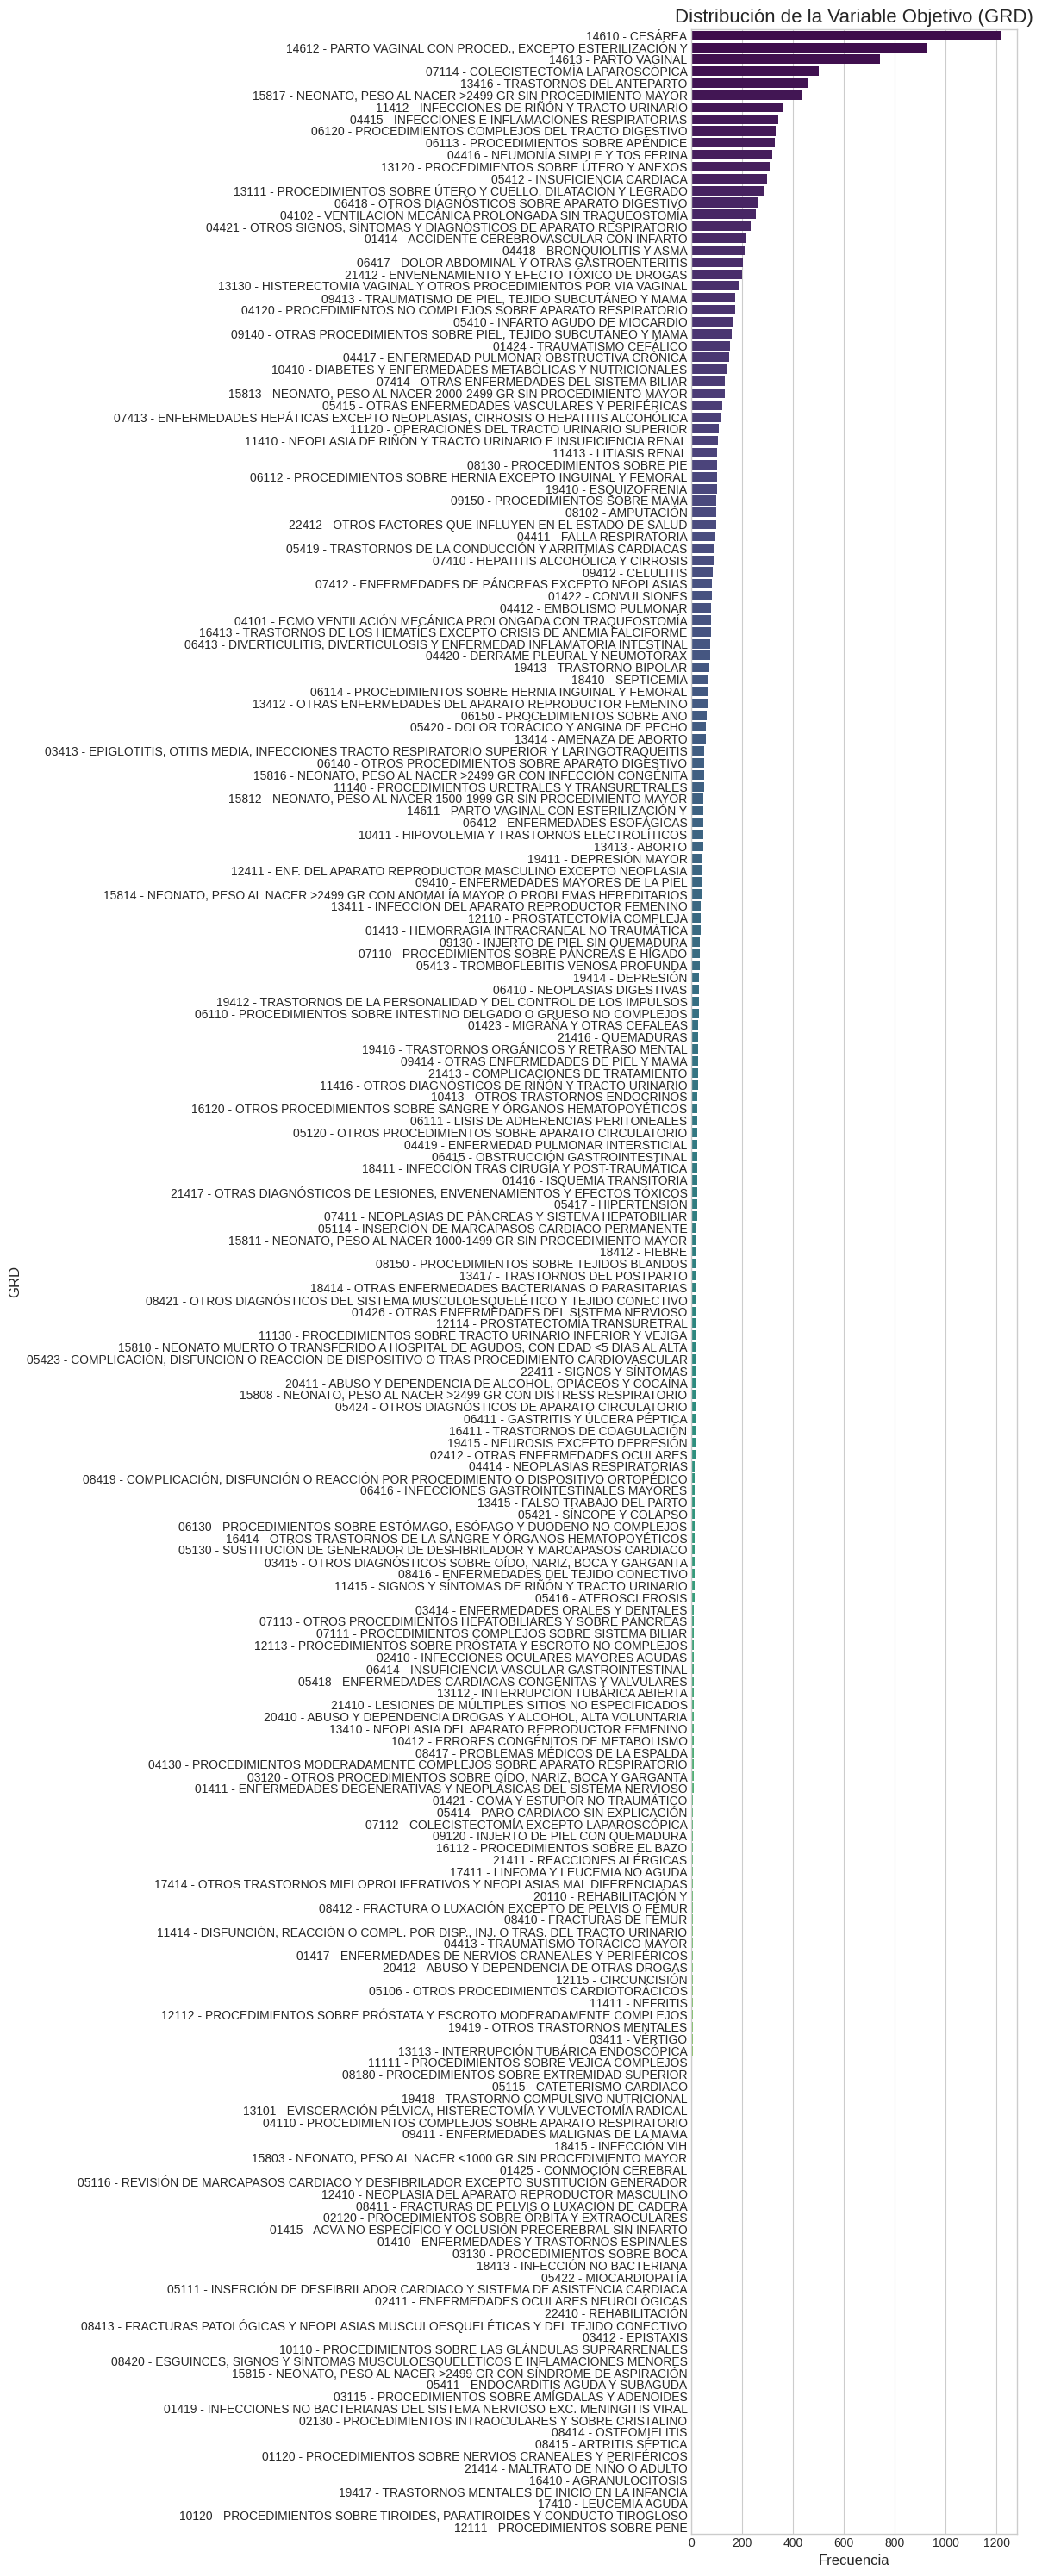

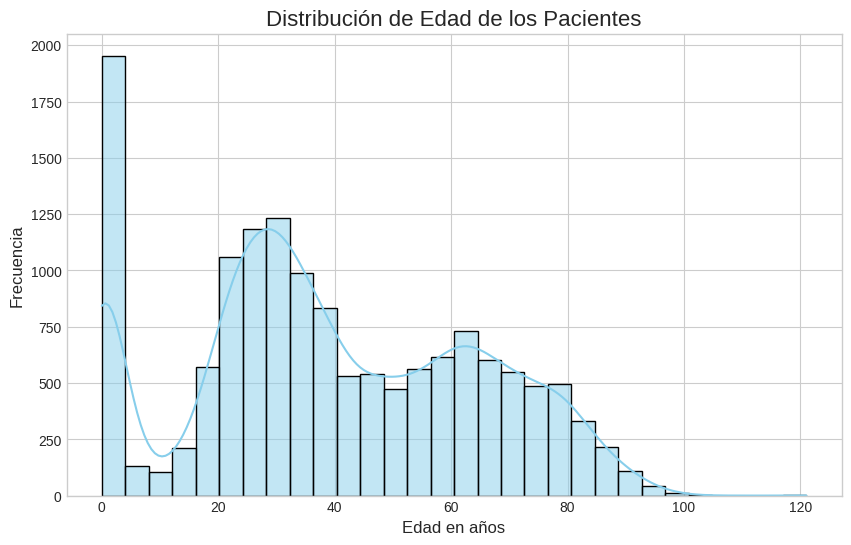

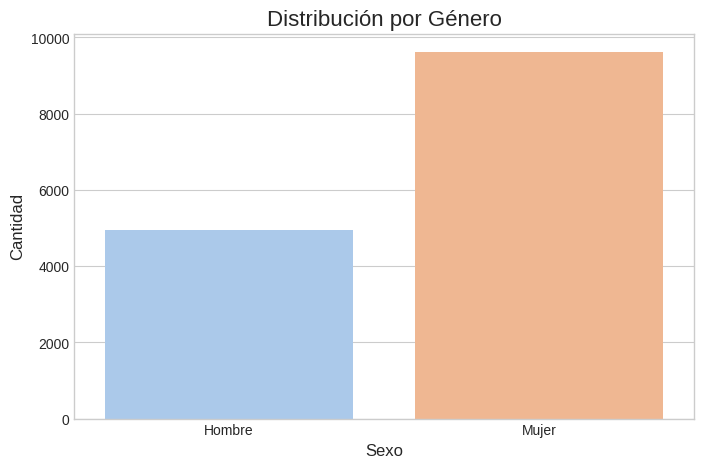

In [17]:
plot_distribucion_label(dset_GRD)
plot_distribucion_edad(dset_GRD)
plot_distribucion_sexo(dset_GRD)

In [18]:
umbral = 0.004
dset_GRD_label_limpio = eliminar_label_por_porcentaje(dset_GRD, 'Label', umbral)

In [19]:
porcentaje_filas_limite = 75
dset_GRD_filas_limpias = eliminar_filas_nulas_x_porcentaje(dset_GRD_label_limpio,porcentaje_filas_limite)

Paso 1: Reemplazando '-' con valores nulos (NaN)...
Paso 2: Eliminando filas con más de un 75% de valores nulos...
¡Limpieza completada!


In [20]:
porcentaje_columnas_limite = 75
dset_GRD_columnas_limpias = eliminar_columnas_nulas_x_porcentaje(dset_GRD_filas_limpias, porcentaje_columnas_limite)

Columnas a eliminar (35): ['Diag 12 Secundario (cod+des)', 'Diag 13 Secundario (cod+des)', 'Diag 14 Secundario (cod+des)', 'Diag 15 Secundario (cod+des)', 'Diag 16 Secundario (cod+des)', 'Diag 17 Secundario (cod+des)', 'Diag 18 Secundario (cod+des)', 'Diag 19 Secundario (cod+des)', 'Diag 20 Secundario (cod+des)', 'Diag 21 Secundario (cod+des)', 'Diag 22 Secundario (cod+des)', 'Diag 23 Secundario (cod+des)', 'Diag 24 Secundario (cod+des)', 'Diag 25 Secundario (cod+des)', 'Diag 26 Secundario (cod+des)', 'Diag 27 Secundario (cod+des)', 'Diag 28 Secundario (cod+des)', 'Diag 29 Secundario (cod+des)', 'Diag 30 Secundario (cod+des)', 'Diag 31 Secundario (cod+des)', 'Diag 32 Secundario (cod+des)', 'Diag 33 Secundario (cod+des)', 'Diag 34 Secundario (cod+des)', 'Diag 35 Secundario (cod+des)', 'Proced 20 Secundario (cod+des)', 'Proced 21 Secundario (cod+des)', 'Proced 22 Secundario (cod+des)', 'Proced 23 Secundario (cod+des)', 'Proced 24 Secundario (cod+des)', 'Proced 25 Secundario (cod+des)', '

In [21]:
dset_GRD_inputar_numericas_avg = imputar_numericas_con_mediana(dset_GRD_columnas_limpias)

In [22]:
dataset_GRD_ = imputar_categoricas_con_moda(dset_GRD_inputar_numericas_avg)

In [23]:
dataset_GRD_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8648 entries, 0 to 14560
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Diag 01 Principal (cod+des)     8648 non-null   object
 1   Diag 02 Secundario (cod+des)    8648 non-null   object
 2   Diag 03 Secundario (cod+des)    8648 non-null   object
 3   Diag 04 Secundario (cod+des)    8648 non-null   object
 4   Diag 05 Secundario (cod+des)    8648 non-null   object
 5   Diag 06 Secundario (cod+des)    8648 non-null   object
 6   Diag 07 Secundario (cod+des)    8648 non-null   object
 7   Diag 08 Secundario (cod+des)    8648 non-null   object
 8   Diag 09 Secundario (cod+des)    8648 non-null   object
 9   Diag 10 Secundario (cod+des)    8648 non-null   object
 10  Diag 11 Secundario (cod+des)    8648 non-null   object
 11  Proced 01 Principal (cod+des)   8648 non-null   object
 12  Proced 02 Secundario (cod+des)  8648 non-null   obje

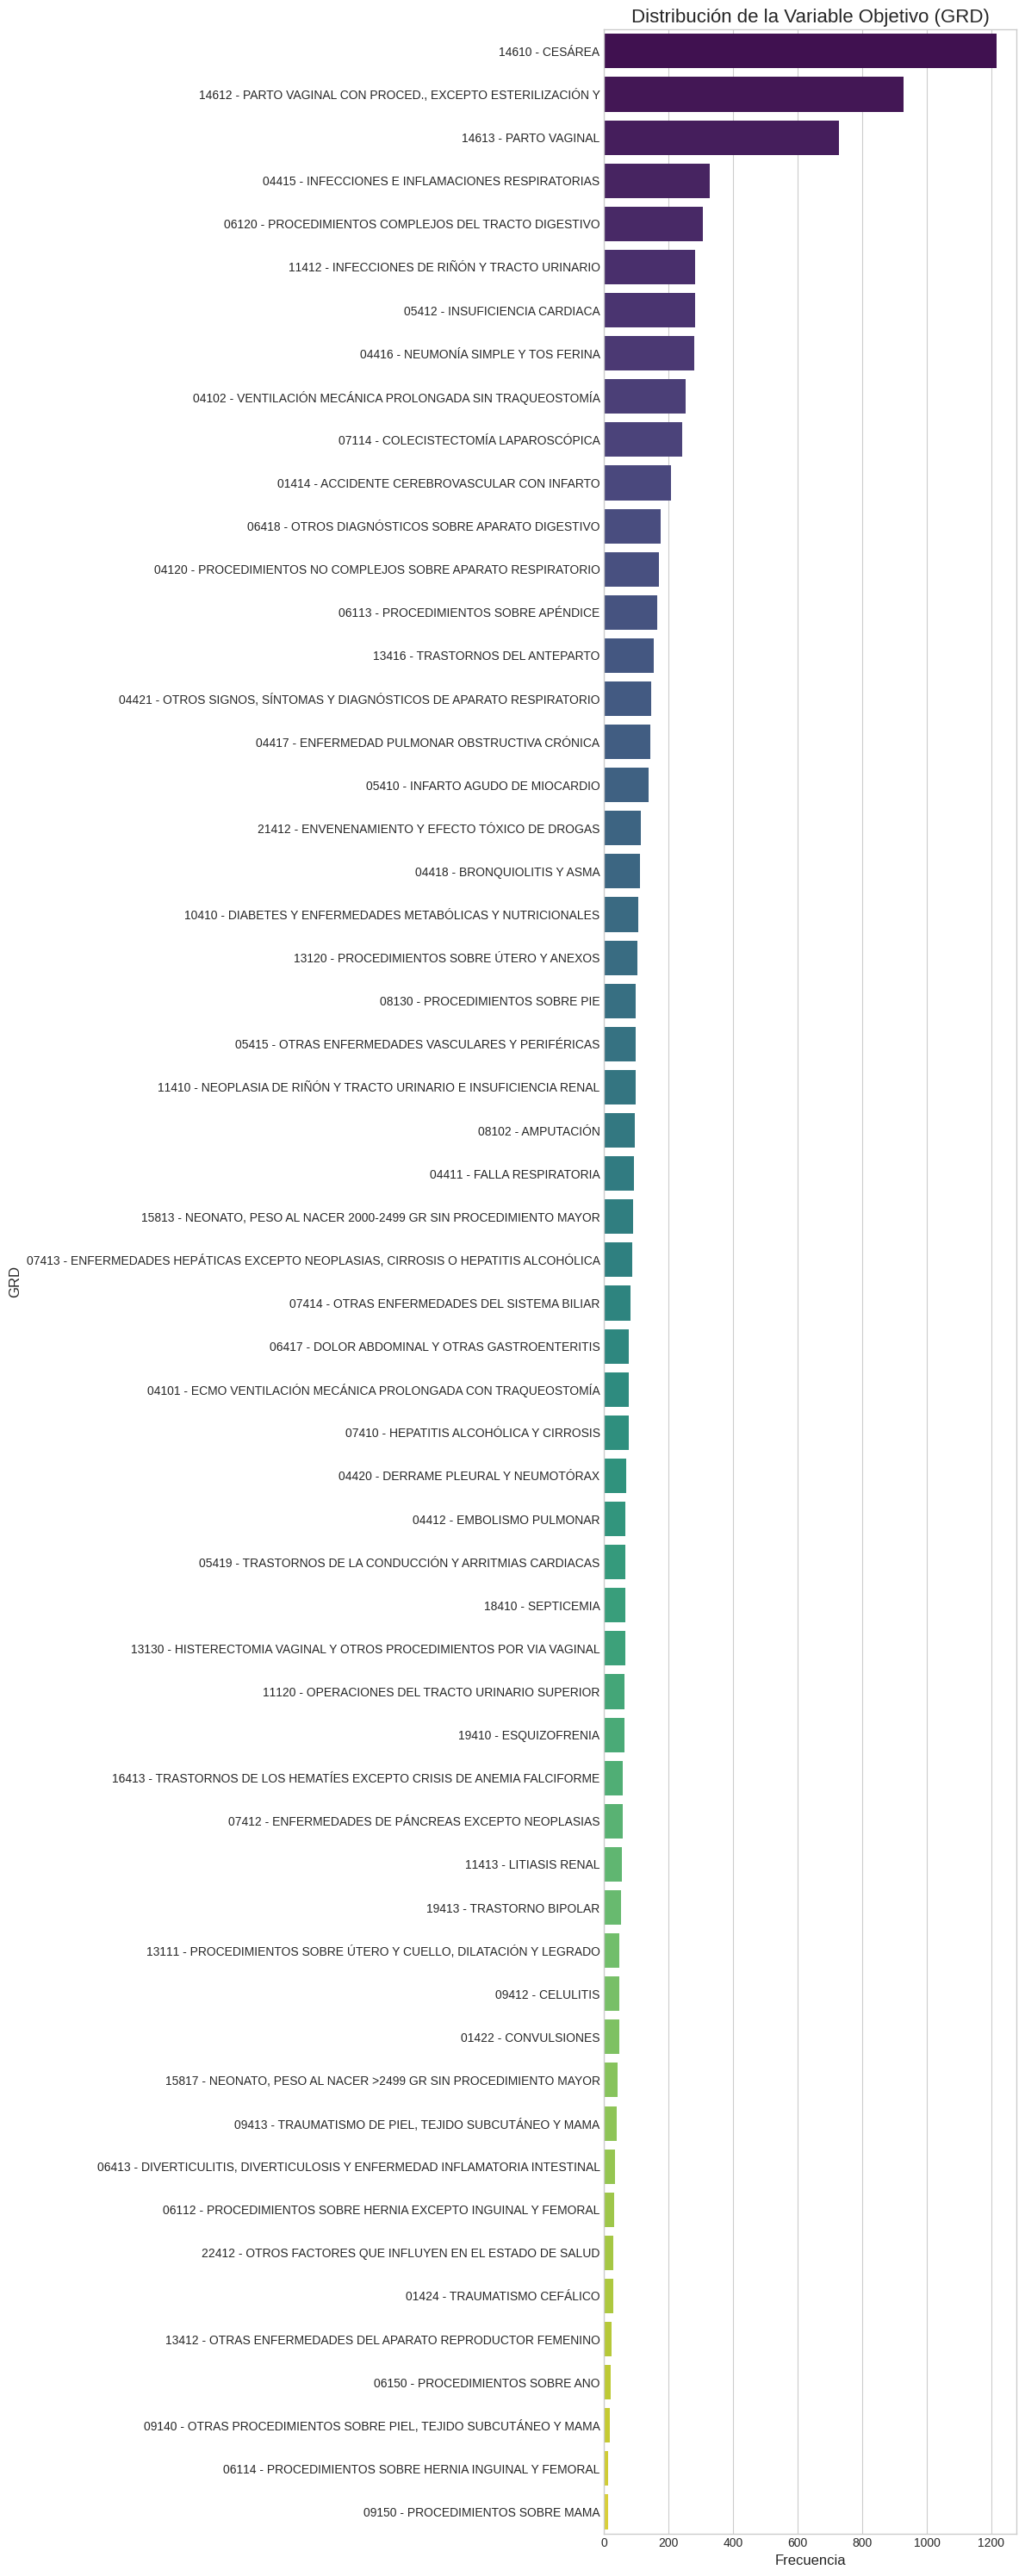

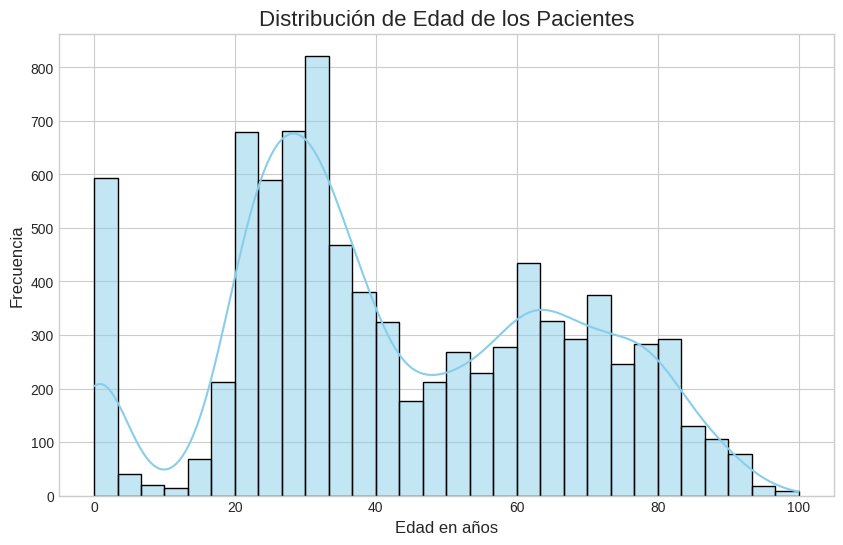

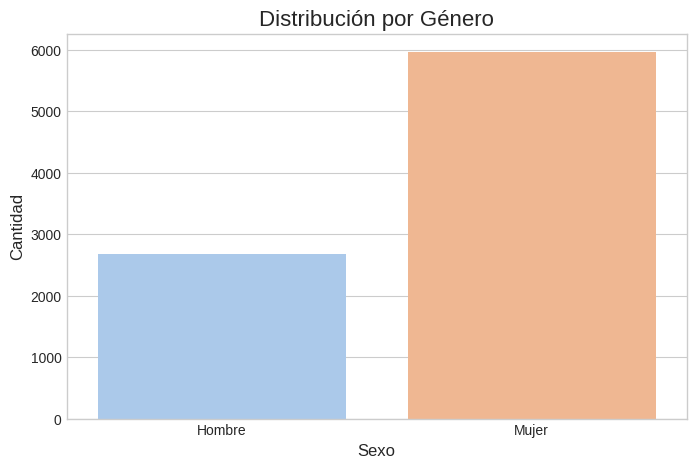

In [24]:
plot_distribucion_label(dataset_GRD_)
plot_distribucion_edad(dataset_GRD_)
plot_distribucion_sexo(dataset_GRD_)

In [25]:
# --- 1. Limpieza y Extracción de Códigos (igual que antes) ---
diag_cols = [f'Diag {i:02d} Principal (cod+des)' for i in range(1, 2)] + \
            [f'Diag {i:02d} Secundario (cod+des)' for i in range(2, 10)]

proced_cols = [f'Proced {i:02d} Principal (cod+des)' for i in range(1, 2)] + \
            [f'Proced {i:02d} Secundario (cod+des)' for i in range(2, 10)]

for col in diag_cols:
    if col in dataset_GRD_.columns:
        dataset_GRD_[col] = dataset_GRD_[col].str.split(' - ').str[0]

for col in proced_cols:
    if col in dataset_GRD_.columns:
        dataset_GRD_[col] = dataset_GRD_[col].str.split(' - ').str[0]

In [26]:
# --- 2. Selección de Características (igual que antes) ---
features = ['Edad en años', 'Sexo (Desc)'] + [col for col in diag_cols if col in dataset_GRD_.columns] + [col for col in proced_cols if col in dataset_GRD_.columns]
target = 'Label'

dataset_GRD_.dropna(subset=[target], inplace=True)

X = dataset_GRD_[features]
y = dataset_GRD_[target]

In [27]:
# --- 3. Definir transformadores para cada tipo de columna ---
numeric_features = ['Edad en años']
categorical_features = ['Sexo (Desc)']
diag_features = [col for col in diag_cols if col in dataset_GRD_.columns]
proced_features = [col for col in proced_cols if col in dataset_GRD_.columns]

# Pipelines para numéricas y categóricas (igual que antes)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para características de diagnóstico usando TargetEncoder
diag_transformer_target = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # El TargetEncoder aprenderá a mapear cada código a la media del target 'y'
    ('target_encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))
])
# Pipeline para características de procedimientos usando TargetEncoder
proced_transformer_target = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # El TargetEncoder aprenderá a mapear cada código a la media del target 'y'
    ('target_encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))
])

In [28]:
# --- 4. Crear el preprocesador con ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('diag', diag_transformer_target, diag_features),
        ('proced', proced_transformer_target, proced_features)
    ],
    remainder='drop'
)

# Dividir los datos ANTES de cualquier entrenamiento es crucial para TargetEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Pipeline de preprocesamiento con TargetEncoder generado con éxito.")
print("Dimensiones de X_train procesado:", X_train.shape)
print("Dimensiones de X_test procesado:", X_test.shape)

Pipeline de preprocesamiento con TargetEncoder generado con éxito.
Dimensiones de X_train procesado: (6918, 20)
Dimensiones de X_test procesado: (1730, 20)


In [29]:
# 2. Definir los modelos y sus grids de parámetros (Corregido con prefijo 'model__')
param_grids = {
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'pca__n_components': [0.95, 0.97, 0.99],
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_leaf': [1, 2]
        }
    },
    "LightGBM": {
        'model': lgb.LGBMClassifier(random_state=42),
        'params': {
            'pca__n_components': [0.95, 0.97, 0.99],
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [31, 40]
        }
    }
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_estimators = {}

print("Param grids updated with 'model__' prefix.")

Param grids updated with 'model__' prefix.


In [30]:
# 3. Bucle para crear el pipeline y ejecutar GridSearchCV
print("--- Iniciando Búsqueda de Hiperparámetros con Resampling en Pipeline ---")
for name, config in param_grids.items():
    print(f"Ajustando hiperparámetros para: {name}...")

    # --- 4. CREACIÓN DEL PIPELINE DE IMBLEARN ---
    # Este es el paso clave. Creamos un pipeline que contiene:
    # 1. Tu preprocesador
    # 2. El remuestreador SMOTETomek
    # 3. El modelo a entrenar

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', SMOTETomek(random_state=42)),
        ('pca', PCA(random_state=42)),
        ('model', config['model'])
    ])

    # Crear la instancia de GridSearchCV usando el pipeline
    grid_search = GridSearchCV(
        estimator=pipeline, # Le pasamos el pipeline completo
        param_grid=config['params'], # El grid con los prefijos
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    # Ajustar el grid search a los datos originales (sin procesar ni remuestrear)
    # El pipeline se encarga de todo internamente
    grid_search.fit(X_train, y_train)

    # Guardar los mejores resultados
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }
    best_estimators[name] = grid_search.best_estimator_

    print(f"Mejor F1-score ponderado para {name}: {grid_search.best_score_:.4f}")
    # Los mejores parámetros se mostrarán con el prefijo 'model__'
    print(f"Mejores parámetros: {grid_search.best_params_}\n")

--- Iniciando Búsqueda de Hiperparámetros con Resampling en Pipeline ---
Ajustando hiperparámetros para: Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejor F1-score ponderado para Random Forest: 0.4907
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 100, 'pca__n_components': 0.99}

Ajustando hiperparámetros para: LightGBM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 56302, number of used features: 14
[LightGBM] [Info] Start training from score -4.058101
[LightGBM] [Info] Start training from score -4.058101
[LightGBM] [Info] Start training from score -4.058101
[LightGBM] [Info] Start training from score -4.058101
[LightGBM] [Info] St


--- Tabla Comparativa de Modelos Optimizados ---
          Modelo  Mejor F1-score Ponderado (CV)  \
0  Random Forest                       0.490744   
1       LightGBM                       0.490532   

                                                                                           Mejores Hiperparámetros  
0  {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 100, 'pca__n_components': 0.99}  
1   {'model__learning_rate': 0.05, 'model__n_estimators': 200, 'model__num_leaves': 31, 'pca__n_components': 0.95}  


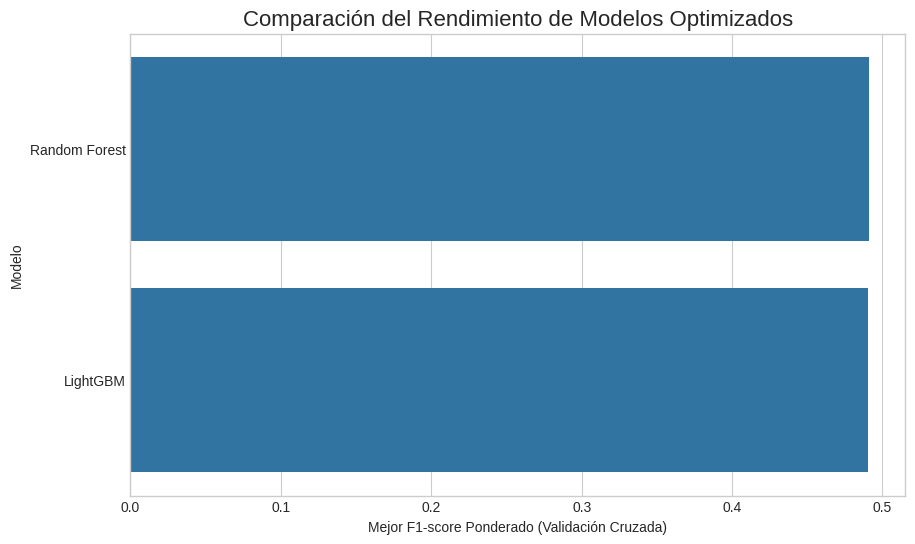

In [31]:
# 4. Presentar resultados (adaptado a la nueva salida)

# Crear un DataFrame para la tabla comparativa
summary_list = []
for name, result in results.items():
    summary_list.append({
        'Modelo': name,
        'Mejor F1-score Ponderado (CV)': result['best_score'],
        'Mejores Hiperparámetros': str(result['best_params'])
    })

summary_df = pd.DataFrame(summary_list)

print("\n--- Tabla Comparativa de Modelos Optimizados ---")
# Para mejorar la visualización de la tabla
pd.set_option('display.max_colwidth', None)
print(summary_df)

# Visualización (Opcional, pero útil)
plt.figure(figsize=(10, 6))
sns.barplot(x='Mejor F1-score Ponderado (CV)', y='Modelo', data=summary_df.sort_values('Mejor F1-score Ponderado (CV)', ascending=False))
plt.title('Comparación del Rendimiento de Modelos Optimizados', fontsize=16)
plt.xlabel('Mejor F1-score Ponderado (Validación Cruzada)')
plt.ylabel('Modelo')
plt.show()

In [32]:
# Ejemplo de cómo usar el mejor modelo para predecir en el conjunto de prueba
print("\n--- Ejemplo de predicción con el mejor modelo ---")
best_model_name = summary_df.loc[summary_df['Mejor F1-score Ponderado (CV)'].idxmax()]['Modelo']
best_model = best_estimators[best_model_name]
print(f"El mejor modelo fue: {best_model_name}")

y_pred_test = best_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print(f"F1-score ponderado en el conjunto de prueba: {f1_test:.4f}")


--- Ejemplo de predicción con el mejor modelo ---
El mejor modelo fue: Random Forest
F1-score ponderado en el conjunto de prueba: 0.4714
